In [76]:
import os
import numpy as np
import pandas as pd
import matplotlib
data_folder = "basketball"
data_filename = os.path.join(data_folder, "NBA_Game_Log.csv")

In [77]:
import platform 
import sklearn 
#had to pip install: pip install -U scikit-learn

In [78]:
from sklearn.metrics import f1_score, make_scorer, classification_report
scorer = make_scorer(f1_score, pos_label=None, average = 'weighted')

In [79]:
#Only game data from January 7th 
results = pd.read_csv(data_filename)
results.loc[:5]

,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Box Score,Unnamed: 7,Attend.,Notes
0,"Tue, Jan 7, 2020",10:30p,New York Knicks,87,Los Angeles Lakers,117,Box Score,NaN,18997,NaN
1,"Tue, Jan 7, 2020",9:00p,Sacramento Kings,114,Phoenix Suns,103,Box Score,NaN,14134,NaN
2,"Tue, Jan 7, 2020",8:00p,Minnesota Timberwolves,112,Memphis Grizzlies,119,Box Score,NaN,14117,NaN
3,"Tue, Jan 7, 2020",7:30p,Oklahoma City Thunder,111,Brooklyn Nets,103,Box Score,OT,15677,NaN
4,"Tue, Jan 7, 2020",7:00p,Portland Trail Blazers,101,Toronto Raptors,99,Box Score,NaN,19800,NaN
5,"Tue, Jan 7, 2020",7:00p,Detroit Pistons,115,Cleveland Cavaliers,113,Box Score,NaN,17274,NaN


In [80]:
results.columns = ['Date','Start Time','Visitor Team','VisitorPts','Home Team', 'Home Pts','Score Type','OT?','Attend','Notes']
results.loc[:5]

,Date,Start Time,Visitor Team,VisitorPts,Home Team,Home Pts,Score Type,OT?,Attend,Notes
0,"Tue, Jan 7, 2020",10:30p,New York Knicks,87,Los Angeles Lakers,117,Box Score,NaN,18997,NaN
1,"Tue, Jan 7, 2020",9:00p,Sacramento Kings,114,Phoenix Suns,103,Box Score,NaN,14134,NaN
2,"Tue, Jan 7, 2020",8:00p,Minnesota Timberwolves,112,Memphis Grizzlies,119,Box Score,NaN,14117,NaN
3,"Tue, Jan 7, 2020",7:30p,Oklahoma City Thunder,111,Brooklyn Nets,103,Box Score,OT,15677,NaN
4,"Tue, Jan 7, 2020",7:00p,Portland Trail Blazers,101,Toronto Raptors,99,Box Score,NaN,19800,NaN
5,"Tue, Jan 7, 2020",7:00p,Detroit Pistons,115,Cleveland Cavaliers,113,Box Score,NaN,17274,NaN


In [84]:
#Creating columns to track if the Home Team won
results["HomeWin"] = results['VisitorPts']<results['Home Pts']
y_true = results['HomeWin'].values
results.loc[:5]

,Date,Start Time,Visitor Team,VisitorPts,Home Team,Home Pts,Score Type,OT?,Attend,Notes,HomeWin
0,"Tue, Jan 7, 2020",10:30p,New York Knicks,87,Los Angeles Lakers,117,Box Score,NaN,18997,NaN,True
1,"Tue, Jan 7, 2020",9:00p,Sacramento Kings,114,Phoenix Suns,103,Box Score,NaN,14134,NaN,False
2,"Tue, Jan 7, 2020",8:00p,Minnesota Timberwolves,112,Memphis Grizzlies,119,Box Score,NaN,14117,NaN,True
3,"Tue, Jan 7, 2020",7:30p,Oklahoma City Thunder,111,Brooklyn Nets,103,Box Score,OT,15677,NaN,False
4,"Tue, Jan 7, 2020",7:00p,Portland Trail Blazers,101,Toronto Raptors,99,Box Score,NaN,19800,NaN,False
5,"Tue, Jan 7, 2020",7:00p,Detroit Pistons,115,Cleveland Cavaliers,113,Box Score,NaN,17274,NaN,False


In [85]:
n_games = results['HomeWin'].count()
n_homewins= results['HomeWin'].sum()
win_percentage= n_homewins/n_games

print("Home Win Percentage: {0:.1f}%".format(100 * win_percentage))

Home Win Percentage: 56.8%


In [86]:
#baseline
from sklearn.metrics import f1_score
y_pred = [1] * len(y_true)
print("F1: {:.4f}".format(f1_score(y_true, y_pred, pos_label=None, average='weighted')))

F1: 0.4113


In [87]:
results['HomeLastWin'] = False
results['VisitorLastWin'] = False

In [215]:
#Determining if teams are coming off of a win
from collections import defaultdict
won_last = defaultdict(int)

for index, row in results.iterrows():
    home_team = row['Home Team']
    visitor_team = row['Visitor Team']
    row['HomeLastWin'] = won_last[home_team]
    row['VisitorLastWin'] = won_last[visitor_team]
    results.loc[index] = row
    won_last[home_team] = row["HomeWin"]
    won_last[visitor_team]= not row["HomeWin"]

In [216]:
results.loc[20:25][['Date','Visitor Team','VisitorPts','Home Team',
                  'Home Pts','HomeWin','HomeLastWin','VisitorLastWin']]

,Date,Visitor Team,VisitorPts,Home Team,Home Pts,HomeWin,HomeLastWin,VisitorLastWin
20,"Sat, Jan 4, 2020",New Orleans Pelicans,117,Sacramento Kings,115,False,True,False
21,"Sat, Jan 4, 2020",San Antonio Spurs,118,Milwaukee Bucks,127,True,False,True
22,"Sat, Jan 4, 2020",Detroit Pistons,111,Golden State Warriors,104,False,False,False
23,"Sat, Jan 4, 2020",Charlotte Hornets,123,Dallas Mavericks,120,False,True,False
24,"Sat, Jan 4, 2020",Denver Nuggets,114,Washington Wizards,128,True,True,True
25,"Sat, Jan 4, 2020",Boston Celtics,111,Chicago Bulls,104,False,False,False


In [95]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=14)

In [96]:
#Applying last win
from sklearn.model_selection import cross_val_score
#sklearn.cross_validation dont work 

x_previouswins = results[["HomeLastWin","VisitorLastWin"]].values
clf = DecisionTreeClassifier(random_state=14)
scores = cross_val_score(clf, x_previouswins, y_true, scoring = scorer)
print("Using just the last result from the home and visitor teams")
print('F1:{0:4f}'.format(np.mean(scores)))

Using just the last result from the home and visitor teams
F1:0.446044


In [97]:
#Tracking win streaks

results ['HomeWinStreak'] = 0
results ['VisitorWinStreak'] = 0

from collections import defaultdict
win_streak = defaultdict(int)

for index, row in results.iterrows(): #not really efficient
    home_team = row["Home Team"]
    visitor_team = row['Visitor Team']
    row['HomeWinStreak'] = win_streak[home_team]
    row['VisitorWinStreak'] = win_streak[visitor_team]
    results.loc[index]=row
    if row['HomeWin']:
        win_streak[home_team] += 1
        win_streak[visitor_team] = 0
    else:
        win_streak[home_team] = 0 
        win_streak[visitor_team] += 1 
    results[50:60][['Date','Visitor Team','VisitorPts', 'Home Team',
                    'Home Pts','HomeWinStreak','VisitorWinStreak']]
    

In [217]:
#Applying Win Streak
clf = DecisionTreeClassifier(random_state=14)
X_winstreak = results[['HomeLastWin','VisitorLastWin',
                       'HomeWinStreak','VisitorWinStreak']].values
scores=cross_val_score(clf,X_winstreak,y_true,scoring=scorer)
print('Using whether a win streak is active')
print('F1:{0:.4f}'.format(np.mean(scores)))

Using whether a win streak is active
F1:0.5411


In [99]:
#Implementing previous year standings, this does not account for trades but simply team efficency
#This needs to be upgraded due to injuries and trades for current season
ladder_filename = os.path.join(data_folder,'NBA_Current_Standings.csv')
ladder=pd.read_csv(ladder_filename,skiprows=[0,0],index_col='Team')
ladder[:5]

,Rk,Overall,Home,Road,E,W,A,C,SE,NW,...,Post,≤3,≥10,Oct,Nov,Dec,Jan,Feb,Mar,Apr
Team,,,,,,,,,,,,,,,,,,,,,
Milwaukee Bucks,1,Jun-33,18-Feb,15-Apr,20-Mar,13-Mar,02-Mar,10-0,01-Jul,01-May,...,0-0,01-Feb,19-Mar,02-Feb,15-Jan,13-Feb,01-Mar,0-0,0-0,0-0
Los Angeles Lakers,2,30-Jul,15-Apr,15-Mar,03-Oct,20-Apr,01-Jan,02-Feb,7-0,01-Aug,...,0-0,01-Apr,14-Mar,01-Mar,14-Jan,05-Sep,4-0,0-0,0-0,0-0
Miami Heat,3,27-Oct,17-Jan,09-Oct,19-Apr,06-Aug,02-Jun,8-0,02-May,02-Feb,...,0-0,01-Apr,14-Jun,01-Apr,04-Sep,04-Nov,01-Mar,0-0,0-0,0-0
Denver Nuggets,4,26-Nov,15-Apr,07-Nov,05-Nov,15-Jun,03-May,1-0,02-May,5-0,...,0-0,03-May,05-Aug,02-Mar,02-Oct,06-Oct,01-Mar,0-0,0-0,0-0
Los Angeles Clippers,5,26-Dec,16-Apr,08-Oct,03-Oct,16-Sep,4-0,03-Feb,4-0,03-May,...,0-0,01-May,17-May,02-Apr,04-Oct,05-Oct,01-Feb,0-0,0-0,0-0


In [138]:
#Using Apply Method to apply ranks from previous season
#Going to modify this to current standings

def home_team_ranks_higher(row):
    home_team= row['Home Team']
    visitor_team=row['Visitor Team']
    home_rank= ladder.loc[home_team]["Rk"]
    visitor_rank=ladder.loc[visitor_team]['Rk']
    return home_rank<visitor_rank #ranking higher == lower number

results['HomeTeamRanksHigher'] = results.apply(home_team_ranks_higher, axis = 1)
results[:5][['Date','Visitor Team','VisitorPts','Home Team','Home Pts','HomeWin','HomeTeamRanksHigher']]



,Date,Visitor Team,VisitorPts,Home Team,Home Pts,HomeWin,HomeTeamRanksHigher
0,"Tue, Jan 7, 2020",New York Knicks,87,Los Angeles Lakers,117,True,True
1,"Tue, Jan 7, 2020",Sacramento Kings,114,Phoenix Suns,103,False,False
2,"Tue, Jan 7, 2020",Minnesota Timberwolves,112,Memphis Grizzlies,119,True,True
3,"Tue, Jan 7, 2020",Oklahoma City Thunder,111,Brooklyn Nets,103,False,False
4,"Tue, Jan 7, 2020",Portland Trail Blazers,101,Toronto Raptors,99,False,True


In [218]:
#Applying team rankings
X_homehigher = results[['HomeLastWin','VisitorLastWin','HomeTeamRanksHigher']].values
clf = DecisionTreeClassifier(random_state=14)
scores = cross_val_score(clf,X_homehigher,y_true, scoring=scorer)
print('Using whether the home team is ranked higher')
print('F1:{0:4f}'.format(np.mean(scores)))

Using whether the home team is ranked higher
F1:0.704148


In [103]:
from sklearn.model_selection import learning_curve, GridSearchCV

parameter_space = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                 11, 12, 13,14, 15, 16, 17, 18, 19, 20],
}

clf = DecisionTreeClassifier(random_state=14)
grid = GridSearchCV(clf, parameter_space, scoring=scorer)
grid.fit(X_homehigher,y_true)
print('F1: {0:.4f}'.format(grid.best_score_))


F1: 0.7041


In [104]:
#determines if home team won against the visitor team during their previous encounter
last_match_winner = defaultdict(int)

def home_team_won_last(row):
    home_team=row['Home Team']
    visitor_team = row['Visitor Team']
    
    #sorting for consistent ordering
    teams = tuple(sorted([home_team, visitor_team]))
    result = 1 if last_match_winner[teams] == row['Home Team'] else 0
    #updating for future encounters
    winner = row['Home Team'] if row['HomeWin'] else row ['Visitor Team']
    
    last_match_winner[teams] = winner
    
    return result

results['HomeTeamWonLast'] = results.apply(home_team_won_last, axis=1)

In [105]:
results[90:100][['Date','Visitor Team', 'VisitorPts', 'Home Team', 'Home Pts', 'HomeWin', 'HomeTeamWonLast']]

,Date,Visitor Team,VisitorPts,Home Team,Home Pts,HomeWin,HomeTeamWonLast
90,"Thu, Dec 26, 2019",Memphis Grizzlies,110,Oklahoma City Thunder,97,False,0
91,"Thu, Dec 26, 2019",San Antonio Spurs,98,Dallas Mavericks,102,True,0
92,"Thu, Dec 26, 2019",New York Knicks,94,Brooklyn Nets,82,False,0
93,"Thu, Dec 26, 2019",Washington Wizards,102,Detroit Pistons,132,True,0
94,"Wed, Dec 25, 2019",New Orleans Pelicans,112,Denver Nuggets,100,False,0
95,"Wed, Dec 25, 2019",Los Angeles Clippers,111,Los Angeles Lakers,106,False,0
96,"Wed, Dec 25, 2019",Houston Rockets,104,Golden State Warriors,116,True,0
97,"Wed, Dec 25, 2019",Milwaukee Bucks,109,Philadelphia 76ers,121,True,0
98,"Wed, Dec 25, 2019",Boston Celtics,118,Toronto Raptors,102,False,1
99,"Mon, Dec 23, 2019",Minnesota Timberwolves,104,Golden State Warriors,113,True,0


In [106]:
#Basic Features
X_home_higher = results[['HomeLastWin','VisitorLastWin','HomeTeamRanksHigher','HomeTeamWonLast']].values
clf = DecisionTreeClassifier(random_state=14)
scores = cross_val_score(clf,X_homehigher,y_true, scoring=scorer)
print('Using whether the home team is ranked higher')
print('F1:{0:4f}'.format(np.mean(scores)))

Using whether the home team is ranked higher
F1:0.704148


In [107]:
#Encoding Teams as features
#Some teams play better against each other regardless of standings,for example maybe coaching alligns better against specific teams
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
encoding= LabelEncoder()
encoding.fit(results['Home Team'].values)

LabelEncoder()

In [108]:
#Assigning Numbers to Teams 
home_teams = encoding.transform(results['Home Team'].values)
visitor_teams = encoding.transform(results['Visitor Team'].values)
X_teams = np.vstack([home_teams, visitor_teams]).T
X_teams[:5], X_teams.shape

(array([[13, 19],
        [23, 25],
        [14, 17],
        [ 2, 20],
        [27, 24]]), (553, 2))

In [109]:
onehot = OneHotEncoder()
X_teams = onehot.fit_transform(X_teams).todense()

In [110]:
X_teams.shape

(553, 60)

In [111]:
#If the team matches it will assign a 1, for exmaple if the home team were chicago it would assign a 1 where chicago played
print('Home:',X_teams[0,:30])
print('Visitor:',X_teams[0,:30])

Home: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
Visitor: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]


In [112]:
#Teams(DT)
clf = DecisionTreeClassifier(random_state=14)
scores = cross_val_score(clf,X_teams,y_true, scoring=scorer)
print('F1:{0:4f}'.format(np.mean(scores)))

F1:0.611755


In [113]:
#Comparing Random Forest to Decision Tree
#Teams(RF)
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=14)
scores = cross_val_score(clf,X_teams,y_true, scoring=scorer)
print('F1:{0:4f}'.format(np.mean(scores)))

F1:0.638362


In [114]:
parameter_space = {
    'max_features':[2,10,50,'auto'],
    'n_estimators':[50,100,200],
    'criterion':['gini','entropy'],
    'min_samples_leaf':[1,2,4,6],}

clf = RandomForestClassifier(random_state=14)
grid= GridSearchCV(clf,parameter_space,scoring=scorer)
grid.fit(X_teams,y_true)
print('F1:{0:.4f}'.format(grid.best_score_))
print(grid.best_estimator_)

F1:0.6556
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=50,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=14, verbose=0,
                       warm_start=False)


In [115]:
X_all = np.hstack([X_home_higher,X_teams])
print(X_all.shape)

(553, 64)


In [116]:
#combining our decision tree samples
#all(DT)
clf=DecisionTreeClassifier(random_state=14)
scores=cross_val_score(clf,X_all,y_true,scoring=scorer)
print('F1:{0:.4f}'.format(np.mean(scores)))

F1:0.6071


In [118]:
#allRFTuned
parameter_space = {
    'max_features':[2,10,50,'auto'],
    'n_estimators':[50,100,200],
    'criterion':['gini','entropy'],
    'min_samples_leaf':[1,2,4,6],}
clf = RandomForestClassifier(random_state=14)
grid= GridSearchCV(clf,parameter_space,scoring=scorer)
grid.fit(X_all,y_true)
print('Accuracy:{0:.4f}'.format(grid.best_score_))
print(grid.best_estimator_)

Accuracy:0.7131
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=14, verbose=0,
                       warm_start=False)


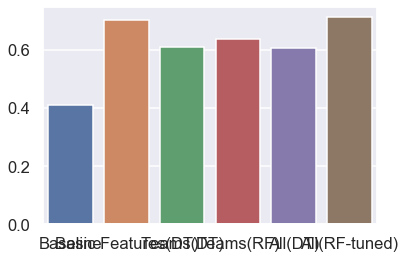

In [119]:
#Comparing all our features. Random Forest tuned will do better compared to other features
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_area_auto_adjustable
labels=['Baseline','Basic Features(DT)','Teams(DT)','Teams(RF)','All(DT)','All(RF-tuned)']
scores = [0.4113,0.704148,0.611755,0.638362,0.6071,0.7131]
sns.set(style='darkgrid',context='talk')
sns.barplot(labels, scores);

In [178]:
#Testing Data on games from Jan 7-9
test_data_filename = os.path.join(data_folder,'Formatted_Test_Data.csv')
games_2020 = pd.read_csv(test_data_filename)
games_2020[:5]

,Date,Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed:1,Unnamed:6,Notes
0,"Thu, Jan 9, 2020",Houston Rockets,92,Oklahoma City Thunder,113,Box Score,NaN,NaN
1,"Thu, Jan 9, 2020",Portland Trail Blazers,102,Minnesota Timberwolves,116,Box Score,NaN,NaN
2,"Thu, Jan 9, 2020",Boston Celtics,98,Philadelphia 76ers,109,Box Score,NaN,NaN
3,"Thu, Jan 9, 2020",Cleveland Cavaliers,115,Detroit Pistons,112,Box Score,OT,NaN
4,"Wed, Jan 8, 2020",Milwaukee Bucks,107,Golden State Warriors,98,Box Score,NaN,NaN


In [179]:
#fixing names
games_2020.columns=['Date','Visitor Team','VisitorPts','Home Team',
                         'HomePts','Score Type','OT?','Notes']

In [150]:
clean_games_2020[:5]

,Date,Visitor Team,VisitorPts,Home Team,HomePts,Score Type,OT?,Notes
0,"Thu, Jan 9, 2020",Houston Rockets,92.0,Oklahoma City Thunder,113.0,Box Score,NaN,NaN
1,"Thu, Jan 9, 2020",Portland Trail Blazers,102.0,Minnesota Timberwolves,116.0,Box Score,NaN,NaN
2,"Thu, Jan 9, 2020",Boston Celtics,98.0,Philadelphia 76ers,109.0,Box Score,NaN,NaN
3,"Thu, Jan 9, 2020",Cleveland Cavaliers,115.0,Detroit Pistons,112.0,Box Score,OT,NaN
4,"Wed, Jan 8, 2020",Milwaukee Bucks,107.0,Golden State Warriors,98.0,Box Score,NaN,NaN


In [180]:
ladder_2020_filename = os.path.join(data_folder,'NBA_Current_Standings.csv')
ladder_2020=pd.read_csv(ladder_filename,skiprows=[0,0],index_col='Team')
ladder_2020[:5]

,Rk,Overall,Home,Road,E,W,A,C,SE,NW,...,Post,≤3,≥10,Oct,Nov,Dec,Jan,Feb,Mar,Apr
Team,,,,,,,,,,,,,,,,,,,,,
Milwaukee Bucks,1,Jun-33,18-Feb,15-Apr,20-Mar,13-Mar,02-Mar,10-0,01-Jul,01-May,...,0-0,01-Feb,19-Mar,02-Feb,15-Jan,13-Feb,01-Mar,0-0,0-0,0-0
Los Angeles Lakers,2,30-Jul,15-Apr,15-Mar,03-Oct,20-Apr,01-Jan,02-Feb,7-0,01-Aug,...,0-0,01-Apr,14-Mar,01-Mar,14-Jan,05-Sep,4-0,0-0,0-0,0-0
Miami Heat,3,27-Oct,17-Jan,09-Oct,19-Apr,06-Aug,02-Jun,8-0,02-May,02-Feb,...,0-0,01-Apr,14-Jun,01-Apr,04-Sep,04-Nov,01-Mar,0-0,0-0,0-0
Denver Nuggets,4,26-Nov,15-Apr,07-Nov,05-Nov,15-Jun,03-May,1-0,02-May,5-0,...,0-0,03-May,05-Aug,02-Mar,02-Oct,06-Oct,01-Mar,0-0,0-0,0-0
Los Angeles Clippers,5,26-Dec,16-Apr,08-Oct,03-Oct,16-Sep,4-0,03-Feb,4-0,03-May,...,0-0,01-May,17-May,02-Apr,04-Oct,05-Oct,01-Feb,0-0,0-0,0-0


In [185]:
#Applying features
games_2020["HomeWin"] = games_2020['VisitorPts']<games_2020['HomePts']
y2020_true = games_2020['HomeWin'].values
games_2020[:5]

,Date,Visitor Team,VisitorPts,Home Team,HomePts,Score Type,OT?,Notes,HomeTeamRanksHigher,HomeWin
0,"Thu, Jan 9, 2020",Houston Rockets,92,Oklahoma City Thunder,113,Box Score,NaN,NaN,False,True
1,"Thu, Jan 9, 2020",Portland Trail Blazers,102,Minnesota Timberwolves,116,Box Score,NaN,NaN,True,True
2,"Thu, Jan 9, 2020",Boston Celtics,98,Philadelphia 76ers,109,Box Score,NaN,NaN,False,True
3,"Thu, Jan 9, 2020",Cleveland Cavaliers,115,Detroit Pistons,112,Box Score,OT,NaN,True,False
4,"Wed, Jan 8, 2020",Milwaukee Bucks,107,Golden State Warriors,98,Box Score,NaN,NaN,False,False


In [191]:
def home_team_ranks_higher_2020(row):
    visitor_team=row['Visitor Team']
    home_rank= ladder_2020.loc[home_team]['Rk']
    visitor_rank=ladder_2020.loc[visitor_team]['Rk']
    return home_rank<visitor_rank #ranking higher == lower number

games_2020['HomeTeamRanksHigher'] = games_2020.apply(home_team_ranks_higher_2020,axis=1)
games_2020[:5]

,Date,Visitor Team,VisitorPts,Home Team,HomePts,Score Type,OT?,Notes,HomeTeamRanksHigher,HomeWin
0,"Thu, Jan 9, 2020",Houston Rockets,92,Oklahoma City Thunder,113,Box Score,NaN,NaN,False,True
1,"Thu, Jan 9, 2020",Portland Trail Blazers,102,Minnesota Timberwolves,116,Box Score,NaN,NaN,True,True
2,"Thu, Jan 9, 2020",Boston Celtics,98,Philadelphia 76ers,109,Box Score,NaN,NaN,False,True
3,"Thu, Jan 9, 2020",Cleveland Cavaliers,115,Detroit Pistons,112,Box Score,OT,NaN,True,False
4,"Wed, Jan 8, 2020",Milwaukee Bucks,107,Golden State Warriors,98,Box Score,NaN,NaN,False,False


In [192]:
games_2020['HomeLastWin']=False
games_2020['VisitorLastWin']=False

for index, row in games_2020.iterrows():
    home_team = row['Home Team']
    visitor_team = row['Visitor Team']
    row['HomeLastWin'] = won_last[home_team]
    row['VisitorLastWin'] = won_last[visitor_team]
    games_2020.loc[index] = row
    won_last[home_team] = row["HomeWin"]
    won_last[visitor_team]= not row["HomeWin"]
games_2020[:5]

,Date,Visitor Team,VisitorPts,Home Team,HomePts,Score Type,OT?,Notes,HomeTeamRanksHigher,HomeWin,HomeLastWin,VisitorLastWin
0,"Thu, Jan 9, 2020",Houston Rockets,92,Oklahoma City Thunder,113,Box Score,NaN,NaN,False,True,False,False
1,"Thu, Jan 9, 2020",Portland Trail Blazers,102,Minnesota Timberwolves,116,Box Score,NaN,NaN,True,True,True,False
2,"Thu, Jan 9, 2020",Boston Celtics,98,Philadelphia 76ers,109,Box Score,NaN,NaN,False,True,True,False
3,"Thu, Jan 9, 2020",Cleveland Cavaliers,115,Detroit Pistons,112,Box Score,OT,NaN,True,False,True,False
4,"Wed, Jan 8, 2020",Milwaukee Bucks,107,Golden State Warriors,98,Box Score,NaN,NaN,False,False,False,True


In [195]:
games_2020['HomeWinStreak']=0
games_2020['VisitorWinStreak']=0

from collections import defaultdict
win_streak=defaultdict(int)

for index, row in games_2020.iterrows():
    home_team=row['Home Team']
    visitor_team=row['Visitor Team']
    row['HomeWinStreak']= win_streak[home_team]
    row['VisitorWinStreak']=win_streak[visitor_team]
    games_2020.loc[index] = row
    
    if row['HomeWin']:
        win_streak[home_team] += 1
        win_streak[visitor_team] = 0
    else:
        win_streak[home_team] = 0
        win_streak[visitor_team] += 1

In [196]:
games_2020['HomeTeamWonLast']=games_2020.apply(home_team_won_last,axis = 1)

In [198]:
games_2020[['Date','Visitor Team','VisitorPts','Home Team','HomePts',
           'HomeWin','HomeLastWin','VisitorLastWin','HomeTeamRanksHigher',
           'HomeWinStreak','VisitorWinStreak','HomeTeamWonLast']][:5]

,Date,Visitor Team,VisitorPts,Home Team,HomePts,HomeWin,HomeLastWin,VisitorLastWin,HomeTeamRanksHigher,HomeWinStreak,VisitorWinStreak,HomeTeamWonLast
0,"Thu, Jan 9, 2020",Houston Rockets,92,Oklahoma City Thunder,113,True,False,False,False,0,0,0
1,"Thu, Jan 9, 2020",Portland Trail Blazers,102,Minnesota Timberwolves,116,True,True,False,True,0,0,0
2,"Thu, Jan 9, 2020",Boston Celtics,98,Philadelphia 76ers,109,True,True,False,False,0,0,1
3,"Thu, Jan 9, 2020",Cleveland Cavaliers,115,Detroit Pistons,112,False,True,False,True,0,0,1
4,"Wed, Jan 8, 2020",Milwaukee Bucks,107,Golden State Warriors,98,False,False,True,False,0,0,0


In [204]:
X_home_higher_2020=games_2020[['HomeLastWin','VisitorLastWin','HomeTeamRanksHigher','HomeTeamWonLast']].values

In [202]:
home_teams_2020=encoding.transform(games_2020['Home Team'].values)
visitor_teams_2020 = encoding.transform(games_2020['Visitor Team'].values)
X_teams_2020=np.vstack([home_teams_2020,visitor_teams_2020]).T
X_teams_2020=onehot.transform(X_teams_2020).todense()

In [206]:
X_all_2020=np.hstack([X_home_higher_2020,X_teams_2020])
X_all_2020.shape

(13, 64)

In [209]:
print('The home team wins {:.2f}% of matches'.format(100*np.mean(y2020_true)))
y_pred = [1] * len(y2020_true)
print('f1: {:.4f}'.format(f1_score(y2020_true,y_pred,pos_label=None,average='weighted')))
print(classification_report(y2020_true,y_pred))

The home team wins 46.15% of matches
f1: 0.2915
              precision    recall  f1-score   support

       False       0.00      0.00      0.00         7
        True       0.46      1.00      0.63         6

    accuracy                           0.46        13
   macro avg       0.23      0.50      0.32        13
weighted avg       0.21      0.46      0.29        13



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [210]:
grid.fit(X_all,y_true)
y_pred = grid.predict(X_all_2020)

In [213]:
from sklearn.metrics import classification_report
print(classification_report(y2020_true,y_pred))

              precision    recall  f1-score   support

       False       0.80      0.57      0.67         7
        True       0.62      0.83      0.71         6

    accuracy                           0.69        13
   macro avg       0.71      0.70      0.69        13
weighted avg       0.72      0.69      0.69        13



In [214]:
print('This results in getting {:.1f}% of predictions correct!'.format(
100*np.mean(y_pred==y2020_true)))

This results in getting 69.2% of predictions correct!
